In [1]:
import numpy as np
import pandas as pd 
import re
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.metrics as mt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import (
    export_graphviz,
    DecisionTreeClassifier,
    DecisionTreeRegressor
)
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay, 
    recall_score,
    precision_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedShuffleSplit,
    cross_val_score,
    RandomizedSearchCV
)

keywords = ["auto","construct","capital_market","chemicals","equipment",
            "transport","semi","bank","steel",
            "telecom","staples","discretionary","kospi"]


In [2]:
dfs = {}  # 빈 딕셔너리 생성
column_names_per_keyword = {}

# 각 키워드에 해당하는 데이터프레임을 dfs 딕셔너리에 추가
for keyword in keywords:
    dfs[keyword] = pd.read_excel('total_raw_0.5ver.xlsx', sheet_name=keyword, header=0, index_col=0)
    column_names_per_keyword[keyword] = dfs[keyword].columns.tolist()

    print(f"Compile {keyword}")

# 각 데이터프레임의 인덱스를 날짜 형식으로 변환한 후 문자열로 변경
for keyword, df in dfs.items():
    df.index = pd.to_datetime(df.index)
    df.index = df.index.strftime('%Y-%m-%d')

# 첫 2개 행을 출력
for keyword, df in dfs.items():
    print(f"Top 2 rows of {keyword}:")
    print(df.head(2))
    print(column_names_per_keyword[keyword])


Compile auto
Compile construct
Compile capital_market
Compile chemicals
Compile equipment
Compile transport
Compile semi
Compile bank
Compile steel
Compile telecom
Compile staples
Compile discretionary
Compile kospi
Top 2 rows of auto:
             auto    WTI  DGS2  DGS10  TIPS    VIX    PPI    per    pbr  \
date                                                                      
2010-04-01  S_buy  84.53  1.05   3.89  1.61  17.47  172.2  24.13  24.13   
2010-04-05  S_buy  86.36  1.18   4.01  1.70  17.02  172.2  24.22  24.22   

               원달러  ...   구리선물_60  중국고정자산투자(yoy%)_60  중국 PMI_60   금 선물_60  \
date                ...                                                     
2010-04-01  1131.3  ...  0.000842          -0.003191  -0.001859 -0.000108   
2010-04-05  1126.0  ...  0.001063          -0.003258  -0.001785 -0.000062   

            달러 인덱스_60  중국 소매판매_60  중국 산업 생산_60  MSCI_EMER_60  US_auto_60  \
date                                                                       
20

In [3]:
data_splits = {}
last_rows = {}  # 각 키워드의 마지막 행을 저장할 딕셔너리

for keyword, df_index in dfs.items():
    # 각 키워드의 마지막 행 추출 및 저장
    last_row = df_index.iloc[-1]  # 마지막 행 저장
    last_rows[keyword] = last_row  # 추출된 마지막 행을 저장
    
    df_dropna = df_index.dropna()  # 결측치가 있는 행 제거
    
    if df_dropna.empty:
        print(f"Error: Dataframe for {keyword} is empty.")
    else:
        # 종속 변수(y) 및 독립 변수(X) 설정
        y_keyword = df_dropna[keyword]  # 현재 키워드에 해당하는 종속 변수
        X_keyword = df_dropna.drop(columns=[keyword])  # 현재 키워드를 제외한 나머지 열은 독립 변수로 사용

        # 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(X_keyword, y_keyword, test_size=0.2, random_state=0)
        
        # 데이터 정규화
        normalizer = StandardScaler()
        X_train_normalized = normalizer.fit_transform(X_train)
        X_test_normalized = normalizer.transform(X_test)

        # 데이터 저장
        data_splits[keyword] = {
            'X_train': X_train_normalized,
            'X_test': X_test_normalized,
            'y_train': y_train,
            'y_test': y_test
        }

        print(f'Train set dimension for {keyword} is {X_train_normalized.shape}')
        print(f'Test set dimension for {keyword} is {X_test_normalized.shape}')
        # 훈련 데이터와 테스트 데이터의 클래스 비율 확인
        train_class_counts = {label: sum(y_train == label) for label in set(y_keyword)}
        test_class_counts = {label: sum(y_test == label) for label in set(y_keyword)}

        print(f"훈련 데이터 클래스 비율 for {keyword}:", train_class_counts)
        print(f"테스트 데이터 클래스 비율 for {keyword}:", test_class_counts)


Train set dimension for auto is (2640, 87)
Test set dimension for auto is (660, 87)
훈련 데이터 클래스 비율 for auto: {'buy': 732, 'S_buy': 619, 'sell': 1289}
테스트 데이터 클래스 비율 for auto: {'buy': 187, 'S_buy': 163, 'sell': 310}
Train set dimension for construct is (2639, 87)
Test set dimension for construct is (660, 87)
훈련 데이터 클래스 비율 for construct: {'buy': 606, 'S_buy': 714, 'sell': 1319}
테스트 데이터 클래스 비율 for construct: {'buy': 149, 'S_buy': 195, 'sell': 316}
Train set dimension for capital_market is (2640, 87)
Test set dimension for capital_market is (660, 87)
훈련 데이터 클래스 비율 for capital_market: {'buy': 661, 'S_buy': 639, 'sell': 1340}
테스트 데이터 클래스 비율 for capital_market: {'buy': 170, 'S_buy': 172, 'sell': 318}
Train set dimension for chemicals is (2640, 87)
Test set dimension for chemicals is (660, 87)
훈련 데이터 클래스 비율 for chemicals: {'buy': 695, 'S_buy': 681, 'sell': 1264}
테스트 데이터 클래스 비율 for chemicals: {'buy': 202, 'S_buy': 159, 'sell': 299}
Train set dimension for equipment is (2640, 87)
Test set dimensi

In [6]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed

# 각 키워드에 대한 최고 성능 모델과 정확도를 저장할 딕셔너리
best_models = {}
best_accuracies = {}

def train_and_evaluate(keyword, data_split):
    X_train = data_split['X_train']
    X_test = data_split['X_test']
    y_train = data_split['y_train']
    y_test = data_split['y_test']
    
    accuracies = {}  # 키워드마다 새로운 accuracies 딕셔너리 생성

    random_forest = RandomForestClassifier()
    gradient_boosting = GradientBoostingClassifier()
    svm = SVC()
    knn = KNeighborsClassifier()
    decision_tree = DecisionTreeClassifier()

    # Voting Classifier 생성
    voting_classifier = VotingClassifier(
        estimators=[
            ('rf', random_forest), 
            ('gb', gradient_boosting), 
            ('svm', svm), 
            ('knn', knn),
            ('dt', decision_tree)
        ],
        voting='hard'
    )

    models = {
        'Random Forest': random_forest,
        'Gradient Boosting': gradient_boosting,
        'Support Vector Machine': svm,
        'K-Nearest Neighbors': knn,
        'Decision Tree': decision_tree,
        'Voting Classifier': voting_classifier
    }

    # 각 분류기에 대해 학습하고 평가
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[name] = accuracy

    # 가장 높은 정확도를 가진 모델 찾기
    best_model_name = max(accuracies, key=accuracies.get)
    best_accuracy = accuracies[best_model_name]
    
    return keyword, best_model_name, best_accuracy

results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(keyword, data_split) for keyword, data_split in data_splits.items())

# 결과 저장 및 출력
for keyword, best_model_name, best_accuracy in results:
    best_models[keyword] = best_model_name
    best_accuracies[keyword] = best_accuracy
    print(f"{keyword}에서 최고의 성능을 보인 모델은 {best_model_name}로, 정확도는 {best_accuracy:.3f}입니다.")

def print_best_model(keyword):
    best_model_name = best_models.get(keyword)
    if best_model_name:
        accuracy = best_accuracies.get(keyword)
        print(f"Best model for {keyword} is {best_model_name} with accuracy {accuracy:.3f}")

# 각 키워드별 최고 성능의 모델 출력
for keyword in data_splits.keys():
    print_best_model(keyword)


auto에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.814입니다.
construct에서 최고의 성능을 보인 모델은 Voting Classifier로, 정확도는 0.827입니다.
capital_market에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.802입니다.
chemicals에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.815입니다.
equipment에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.820입니다.
transport에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.858입니다.
semi에서 최고의 성능을 보인 모델은 Voting Classifier로, 정확도는 0.794입니다.
bank에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.833입니다.
steel에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.809입니다.
telecom에서 최고의 성능을 보인 모델은 Voting Classifier로, 정확도는 0.850입니다.
staples에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.844입니다.
discretionary에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.830입니다.
kospi에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.864입니다.
Best model for auto is Random Forest with accuracy 0.814
Best model for construct is Voting Classifier with accuracy 0.827
Best model for capital_market is Random Forest with accuracy 0.802
Best model for chemicals is Random Forest with accuracy 0.815


In [7]:
# Train set 및 Test set에 대한 성능을 저장할 딕셔너리 생성
performance_results = {}

# Random Forest 모델 생성
rfc = RandomForestClassifier()

# 각 키워드에 대해 모델을 학습하고 Train set 및 Test set에 대한 성능을 측정
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']
    X_test = data_split['X_test']
    y_test = data_split['y_test']
    
    # 모델 학습
    rfc.fit(X_train, y_train)

    # Train set에 대한 성능 측정
    y_pred_train = rfc.predict(X_train)
    acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)

    # Test set에 대한 성능 측정
    y_pred_test = rfc.predict(X_test)
    acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)

    # 결과 저장
    performance_results[keyword] = {
        'Train 성능': acc_train,
        'Test 성능': acc_test
    }

# 각 키워드에 대한 Train set 및 Test set의 성능 출력
for keyword, performance in performance_results.items():
    print(f"{keyword} 키워드에 대한 성능: ", performance['Test 성능'])
    print()


auto 키워드에 대한 성능:  0.8363636363636363

construct 키워드에 대한 성능:  0.8212121212121212

capital_market 키워드에 대한 성능:  0.793939393939394

chemicals 키워드에 대한 성능:  0.8121212121212121

equipment 키워드에 대한 성능:  0.8303030303030303

transport 키워드에 대한 성능:  0.8515151515151516

semi 키워드에 대한 성능:  0.7984848484848485

bank 키워드에 대한 성능:  0.8257575757575758

steel 키워드에 대한 성능:  0.8166666666666667

telecom 키워드에 대한 성능:  0.8560606060606061

staples 키워드에 대한 성능:  0.85

discretionary 키워드에 대한 성능:  0.8227272727272728

kospi 키워드에 대한 성능:  0.8590909090909091



C:\Users\user\AppData\Local\Temp\ipykernel_9224\776093913.py:30: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_9224\776093913.py:30: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_9224\776093913.py:30: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_9224\776093913.py:30: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_9224\776093913.py:30: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_9224\776093913.py:30: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans

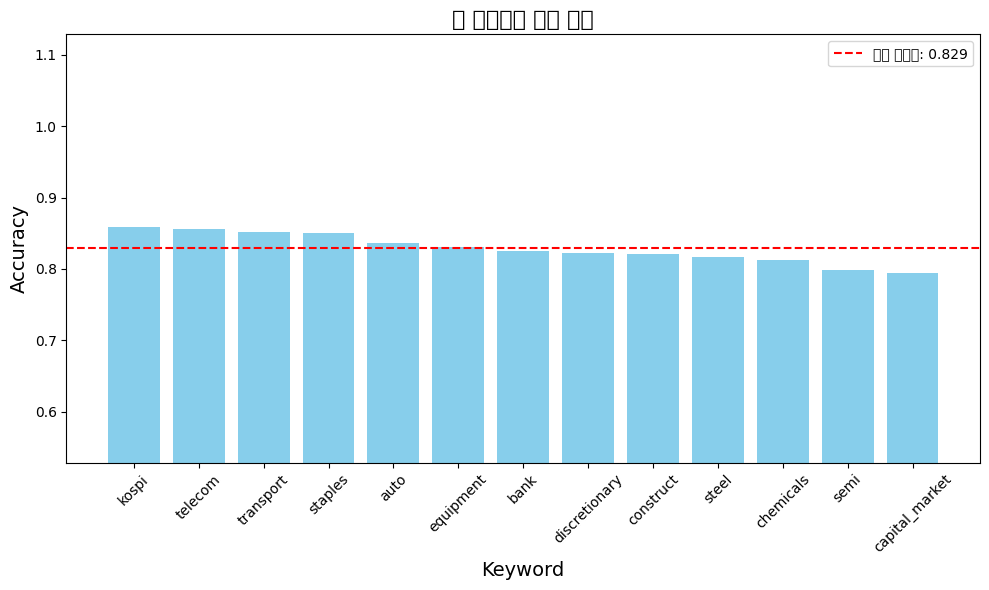

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Train set 및 Test set에 대한 성능 추출
keywords = list(performance_results.keys())
train_accuracies = [performance['Train 성능'] for performance in performance_results.values()]
test_accuracies = [performance['Test 성능'] for performance in performance_results.values()]

# 성능을 내림차순으로 정렬
sorted_indices = sorted(range(len(test_accuracies)), key=lambda i: test_accuracies[i], reverse=True)
sorted_keywords = [keywords[i] for i in sorted_indices]
sorted_test_accuracies = [test_accuracies[i] for i in sorted_indices]

# 그래프 출력
plt.figure(figsize=(10, 6))
plt.bar(sorted_keywords, sorted_test_accuracies, color='skyblue')
plt.xlabel('Keyword', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('각 키워드에 대한 성능', fontsize=16)
plt.xticks(rotation=45)

# 정확도 평균 계산
mean_accuracy = np.mean(sorted_test_accuracies)
plt.axhline(y=mean_accuracy, color='red', linestyle='--', label=f'평균 정확도: {mean_accuracy:.3f}')

# y축 범위 조정하여 확대
plt.ylim(mean_accuracy - 0.3, mean_accuracy + 0.3)

plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


auto 키워드에 대한 최적의 트리 수는 14, 최적의 깊이는 20 입니다.
construct 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 19 입니다.
capital_market 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 15 입니다.
chemicals 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 18 입니다.
equipment 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 19 입니다.
transport 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 19 입니다.
semi 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 14 입니다.
bank 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 15 입니다.
steel 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 19 입니다.
telecom 키워드에 대한 최적의 트리 수는 14, 최적의 깊이는 18 입니다.
staples 키워드에 대한 최적의 트리 수는 18, 최적의 깊이는 19 입니다.
discretionary 키워드에 대한 최적의 트리 수는 16, 최적의 깊이는 17 입니다.
kospi 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 15 입니다.


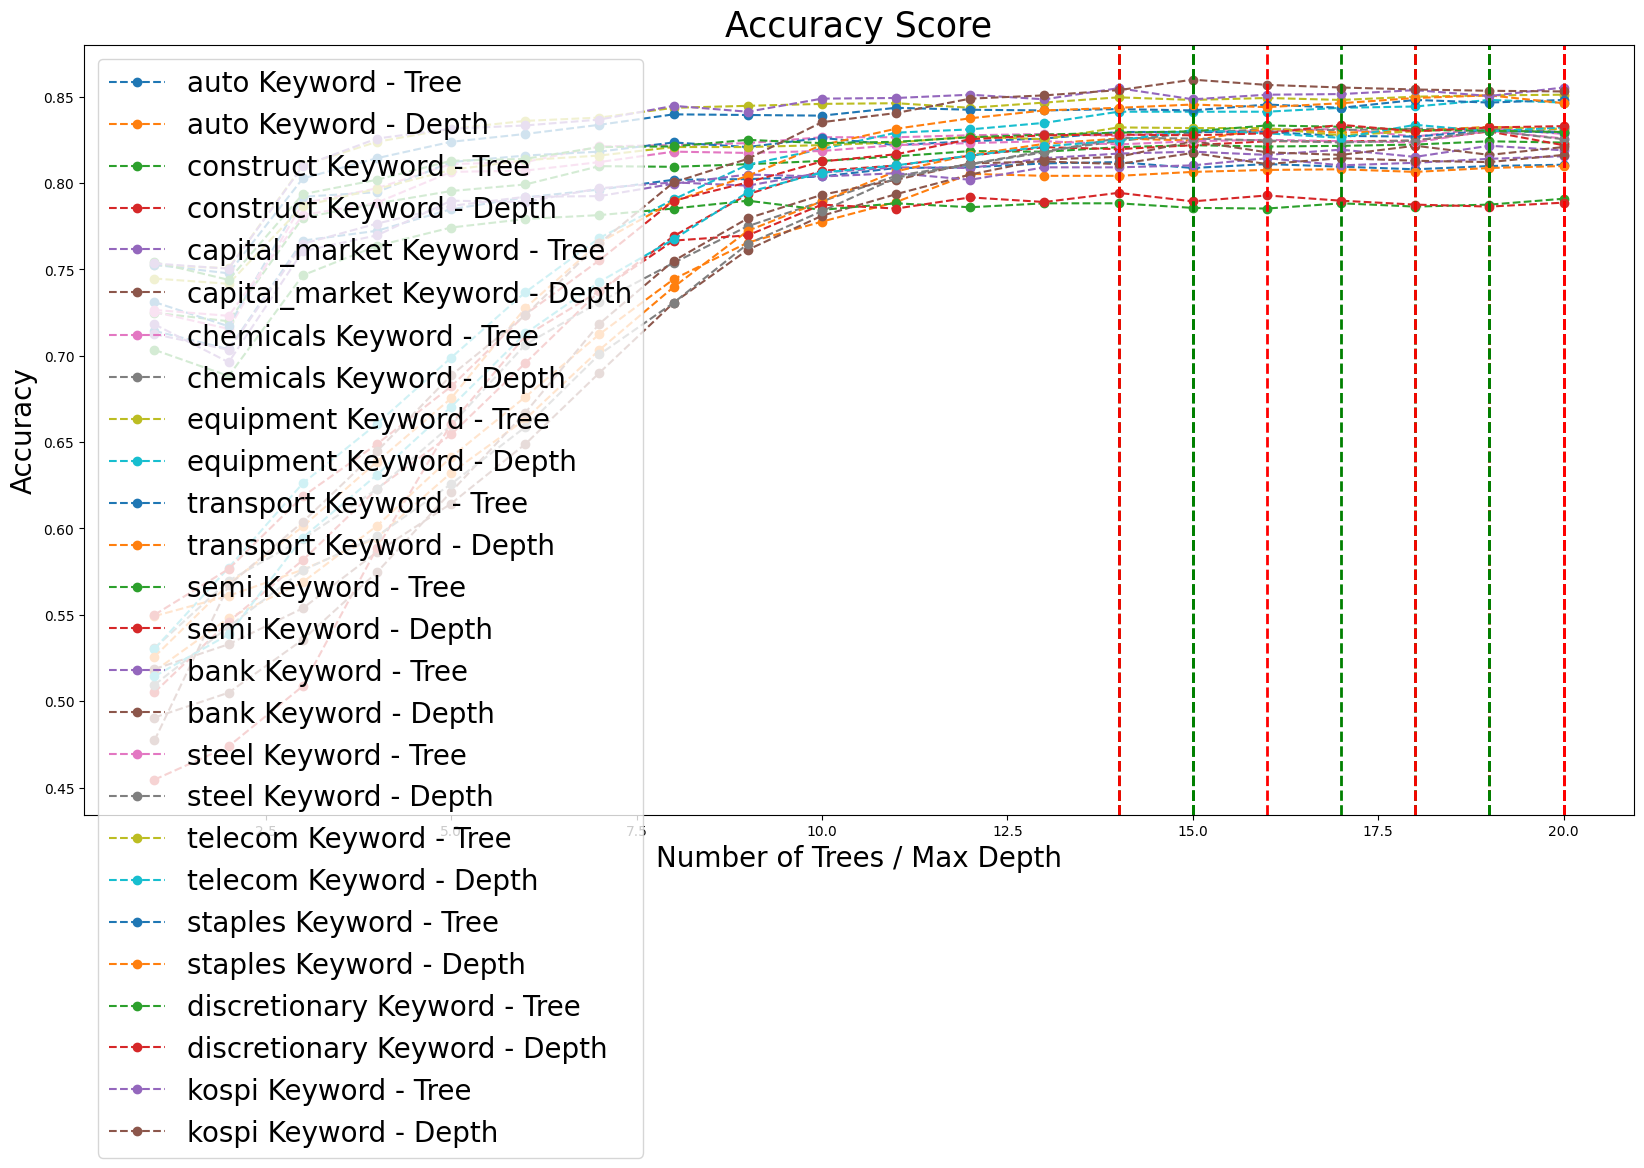

In [9]:
estimator_list = list(range(1, 21))  # 1부터 20까지의 값을 가지는 리스트
depth_list = list(range(1, 21))  # 1부터 20까지의 값을 가지는 리스트
cv_scores_per_keyword = {}  # 각 키워드에 대한 교차 검증 점수를 저장할 딕셔너리
best_estimators_per_keyword = {}  # 각 키워드에 대한 최적의 트리 수를 저장할 딕셔너리
best_depths_per_keyword = {}  # 각 키워드에 대한 최적의 깊이를 저장할 딕셔너리

for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']
    
    cv_scores = []  # 교차 검증 점수를 저장할 리스트
    cv_scores_depth = []  # 교차 검증 점수를 저장할 리스트
    
    for i in tqdm(range(20)):
        rfc = RandomForestClassifier(n_estimators=i+1,
                                     max_leaf_nodes=300,
                                     n_jobs=-1,
                                     random_state=0)
        score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy').mean()
        cv_scores.append(score)

    best_estimator = estimator_list[np.argmax(cv_scores)]
    best_estimators_per_keyword[keyword] = best_estimator
    
    for i in tqdm(range(20)):
        rfc = RandomForestClassifier(n_estimators=best_estimator,
                                     max_depth=i+1,
                                     max_leaf_nodes=300,
                                     n_jobs=-1,
                                     random_state=0)
        score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy').mean()
        cv_scores_depth.append(score)

    best_depth = depth_list[np.argmax(cv_scores_depth)]
    best_depths_per_keyword[keyword] = best_depth
    
    # 교차 검증 점수를 딕셔너리에 저장
    cv_scores_per_keyword[keyword] = {'tree_scores': cv_scores, 'depth_scores': cv_scores_depth}

# 각 키워드에 대한 최적의 트리 수와 깊이 출력
for keyword in data_splits.keys():
    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]
    print(f"{keyword} 키워드에 대한 최적의 트리 수는 {best_estimator}, 최적의 깊이는 {best_depth} 입니다.")

# 각 키워드에 대한 교차 검증 점수 시각화
plt.figure(figsize=(20, 10))
for keyword, scores in cv_scores_per_keyword.items():
    plt.plot(estimator_list, scores['tree_scores'], marker='o', linestyle='dashed', label=f"{keyword} Keyword - Tree")
    plt.plot(depth_list, scores['depth_scores'], marker='o', linestyle='dashed', label=f"{keyword} Keyword - Depth")
plt.legend(fontsize=20)
plt.xlabel("Number of Trees / Max Depth", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
for keyword in data_splits.keys():
    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]
    plt.axvline(best_estimator, color='r', linestyle='--', linewidth=2)
    plt.axvline(best_depth, color='g', linestyle='--', linewidth=2)
plt.show()


auto 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8504
auto 키워드에 대한 Test set에 대한 성능
정확도: 0.8394

민감도: 0.8169
정밀도: 0.8240


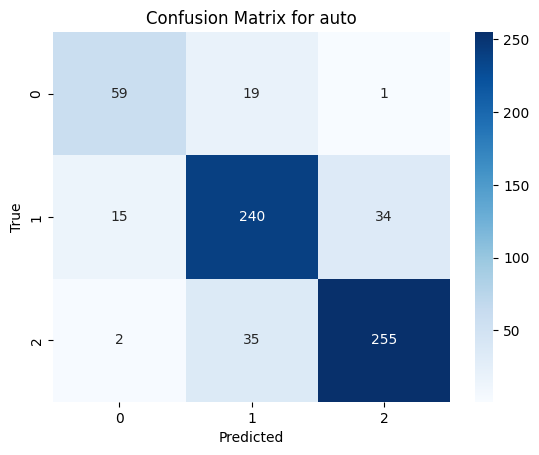

construct 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8496
construct 키워드에 대한 Test set에 대한 성능
정확도: 0.8561

민감도: 0.8295
정밀도: 0.8469


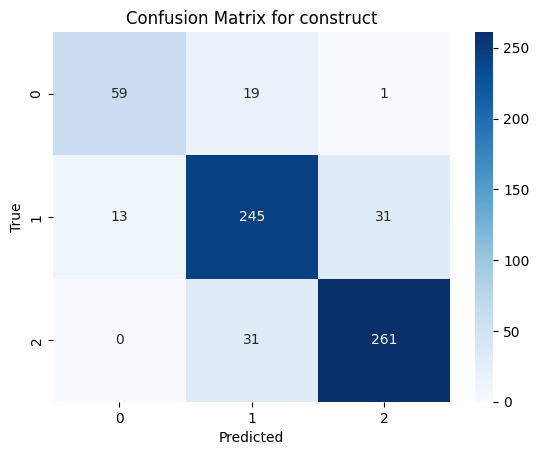

capital_market 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8591
capital_market 키워드에 대한 Test set에 대한 성능
정확도: 0.8485

민감도: 0.8207
정밀도: 0.8496


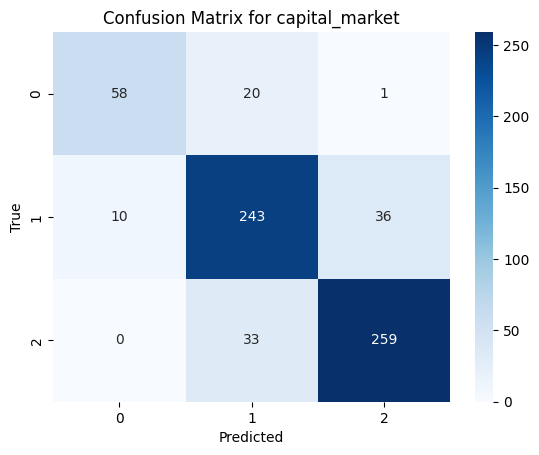

chemicals 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8511
chemicals 키워드에 대한 Test set에 대한 성능
정확도: 0.8485

민감도: 0.8207
정밀도: 0.8434


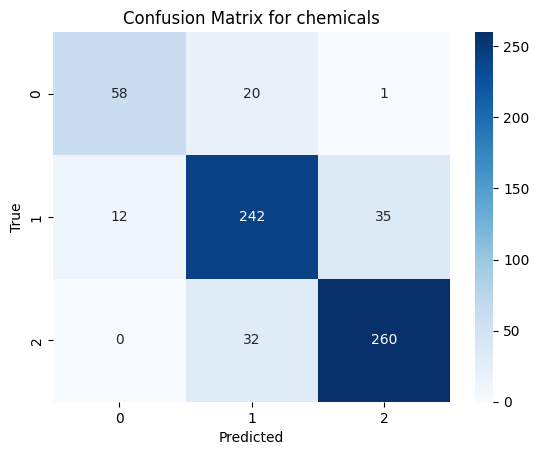

equipment 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8534
equipment 키워드에 대한 Test set에 대한 성능
정확도: 0.8530

민감도: 0.8303
정밀도: 0.8454


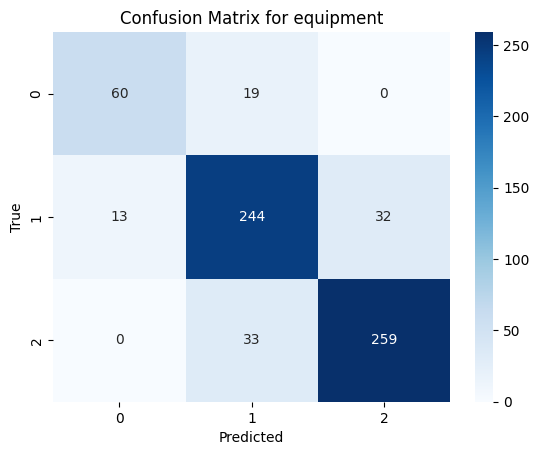

transport 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8496
transport 키워드에 대한 Test set에 대한 성능
정확도: 0.8561

민감도: 0.8295
정밀도: 0.8469


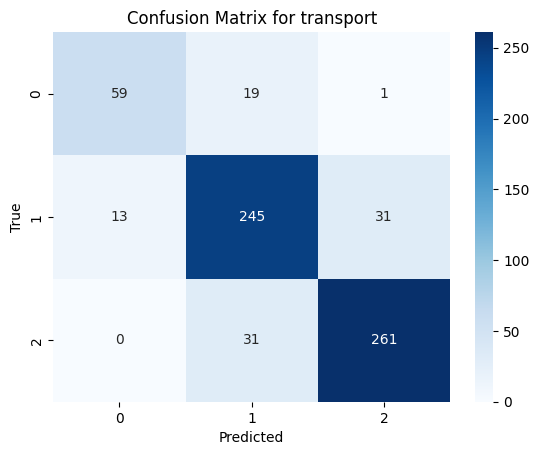

semi 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8538
semi 키워드에 대한 Test set에 대한 성능
정확도: 0.8379

민감도: 0.8126
정밀도: 0.8449


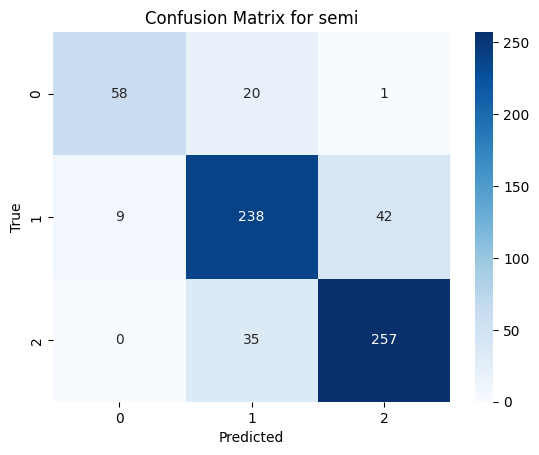

bank 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8598
bank 키워드에 대한 Test set에 대한 성능
정확도: 0.8455

민감도: 0.8214
정밀도: 0.8479


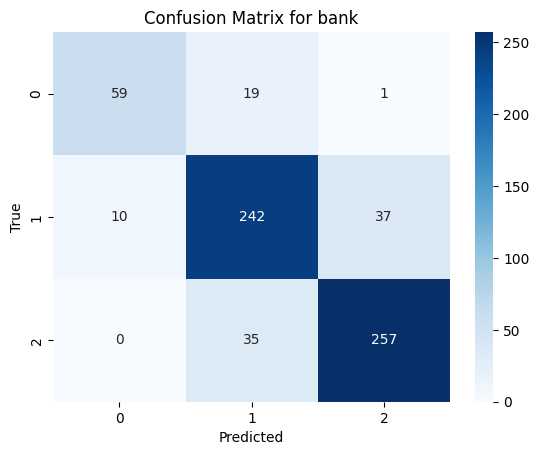

steel 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8496
steel 키워드에 대한 Test set에 대한 성능
정확도: 0.8561

민감도: 0.8295
정밀도: 0.8469


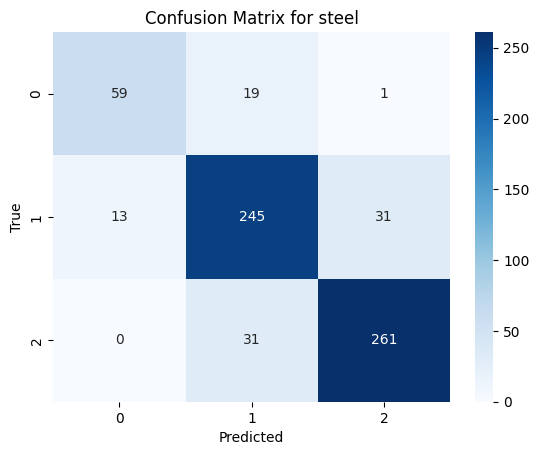

telecom 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8492
telecom 키워드에 대한 Test set에 대한 성능
정확도: 0.8394

민감도: 0.8138
정밀도: 0.8229


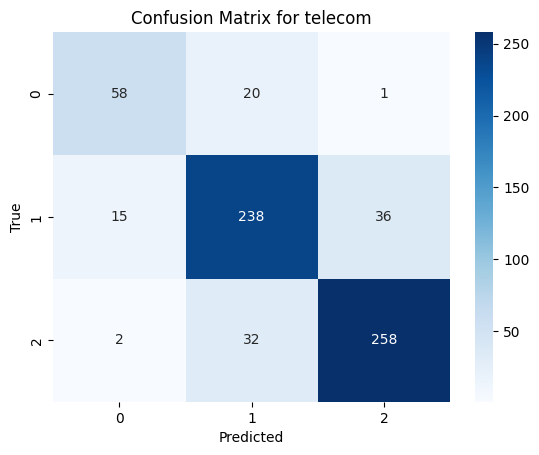

staples 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8527
staples 키워드에 대한 Test set에 대한 성능
정확도: 0.8455

민감도: 0.8245
정밀도: 0.8371


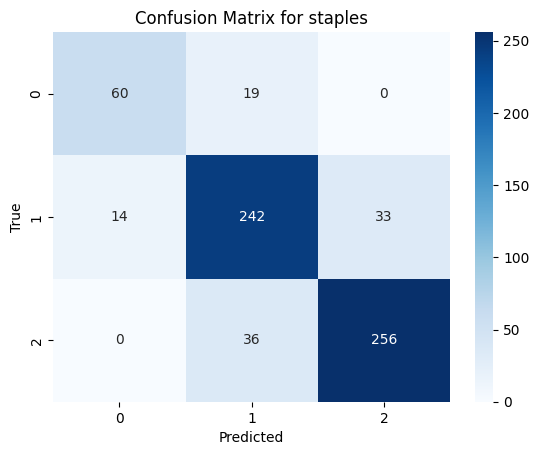

discretionary 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8489
discretionary 키워드에 대한 Test set에 대한 성능
정확도: 0.8379

민감도: 0.8095
정밀도: 0.8317


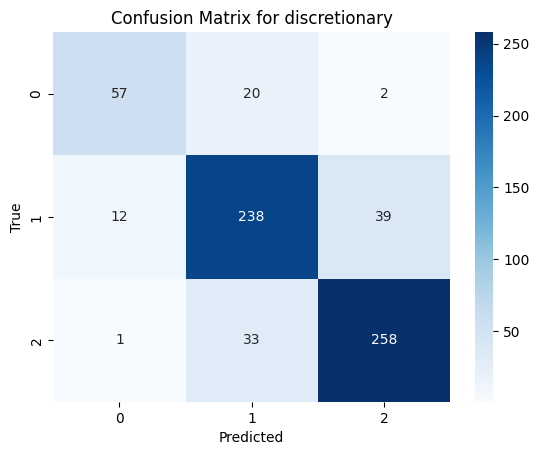

kospi 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8598
kospi 키워드에 대한 Test set에 대한 성능
정확도: 0.8455

민감도: 0.8214
정밀도: 0.8479


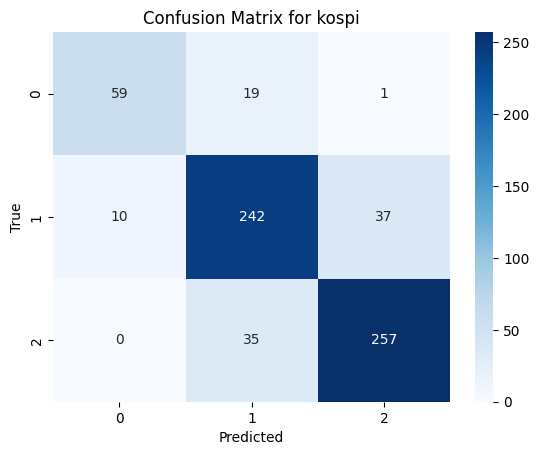

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 각 키워드별 최적의 트리 개수와 최적의 깊이 출력
for keyword in data_splits.keys():
    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]

    # 최적의 트리 개수와 깊이를 사용하여 RandomForestClassifier 초기화
    rfc = RandomForestClassifier(n_estimators=best_estimator, 
                                 max_depth=best_depth, 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)

    # 교차 검증을 통한 정확도 측정
    cv_scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy')

    # 평균 정확도 출력
    print(f"{keyword} 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)")
    print(f"평균 정확도: {cv_scores.mean():.4f}")

    # Train set에 대한 최적의 모델 학습
    rfc.fit(X_train, y_train)

    # Test set에 대한 예측값 생성
    y_pred = rfc.predict(X_test)

    # Test set에 대한 정확도 계산 및 출력
    acc_test = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(f"{keyword} 키워드에 대한 Test set에 대한 성능")
    print(f"정확도: {acc_test:.4f}\n")

    # Test set에 대한 민감도와 정밀도 계산
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')

    # 민감도와 정밀도 출력
    print(f"민감도: {recall:.4f}")
    print(f"정밀도: {precision:.4f}")

    # 혼동 행렬 생성
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {keyword}')
    plt.show()


auto 키워드의 상위 5개 특성:
Feature Name: 구리선물_60, Importance: 0.0235
Feature Name: export_60, Importance: 0.0199
Feature Name: export_auto_20, Importance: 0.0194
Feature Name: 중국 산업 생산_60, Importance: 0.0191
Feature Name: 달러 인덱스_60, Importance: 0.0189

auto 키워드의 하위 5개 특성:
Feature Name: cpi, Importance: 0.0064
Feature Name: VIX, Importance: 0.0064
Feature Name: US_auto, Importance: 0.0054
Feature Name: MSCI_EMER, Importance: 0.0046
Feature Name: T10Y2Y, Importance: 0.0023

construct 키워드의 상위 5개 특성:
Feature Name: 중국 산업 생산, Importance: 0.0233
Feature Name: TIPS, Importance: 0.0228
Feature Name: 원달러_60, Importance: 0.0226
Feature Name: 구리선물_60, Importance: 0.0208
Feature Name: 매매가격지수_60, Importance: 0.0189

construct 키워드의 하위 5개 특성:
Feature Name: yield_gap(%), Importance: 0.0050
Feature Name: T10Y2Y, Importance: 0.0044
Feature Name: MSCI_EMER, Importance: 0.0000
Feature Name: MSCI_EMER_20, Importance: 0.0000
Feature Name: MSCI_EMER_60, Importance: 0.0000

capital_market 키워드의 상위 5개 특성:
Feature Name:

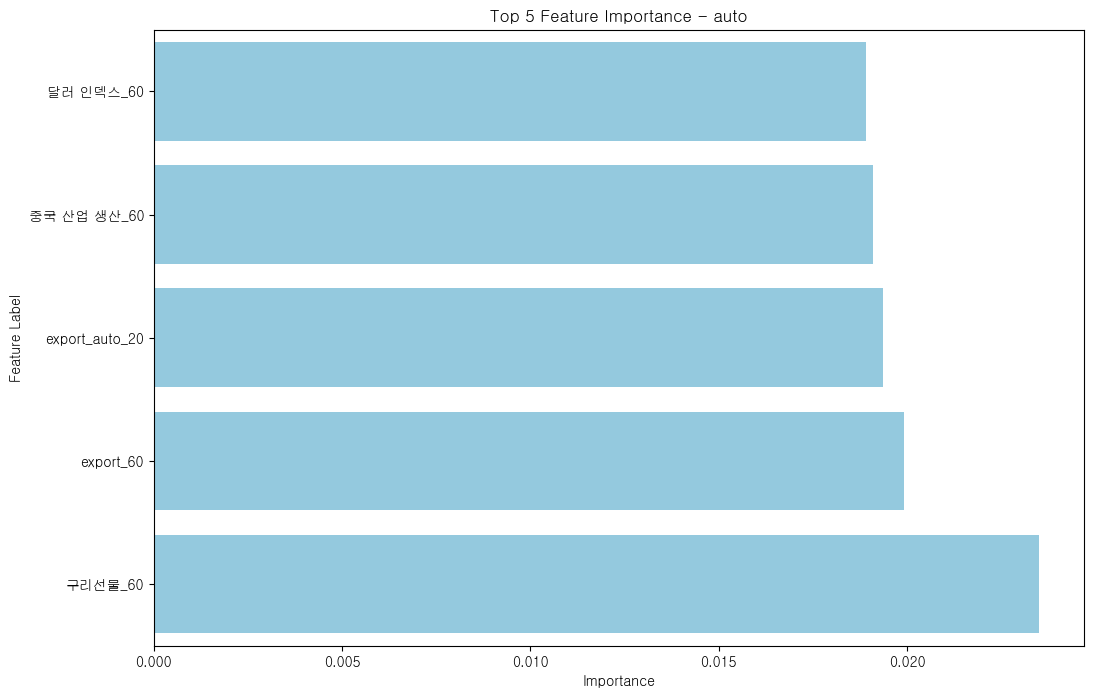

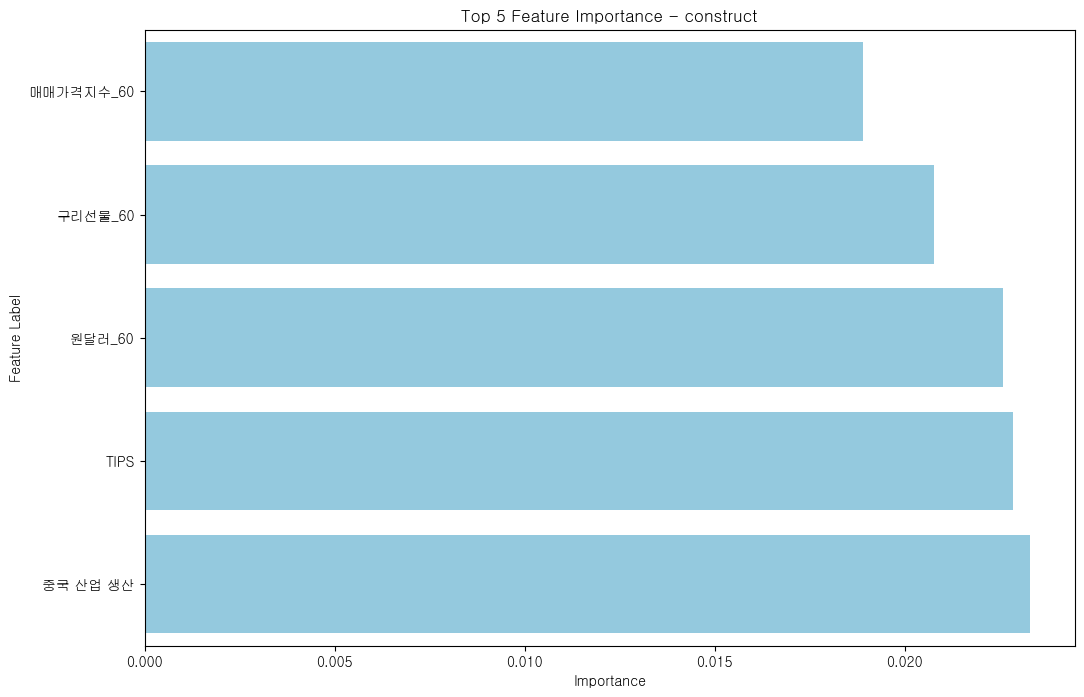

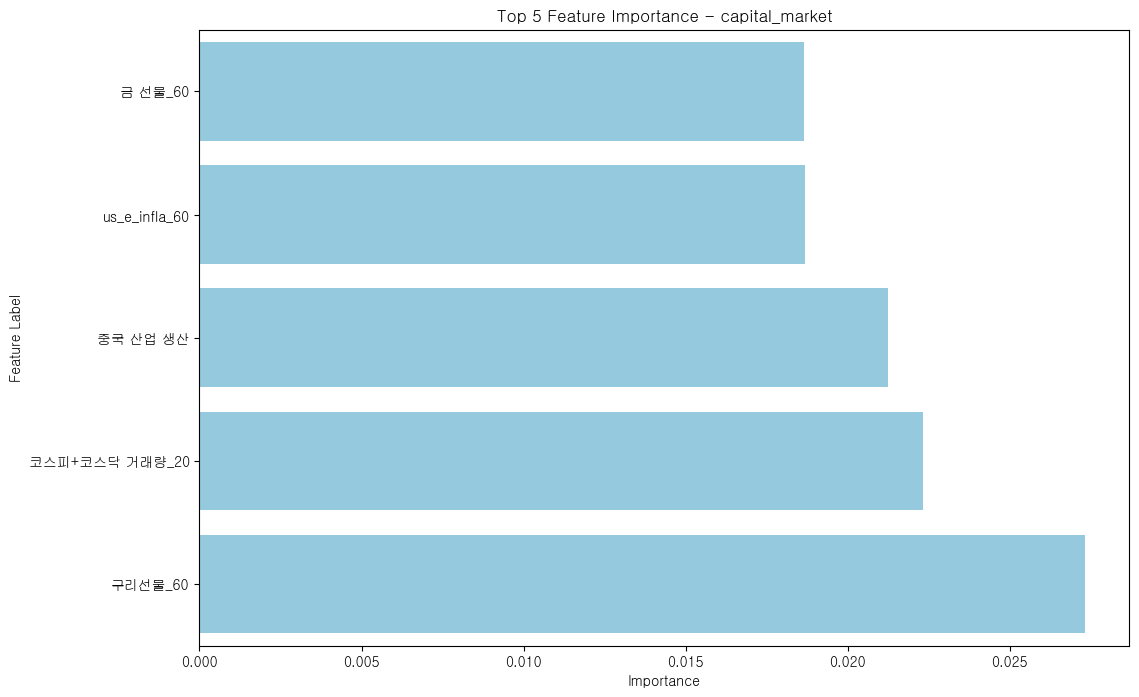

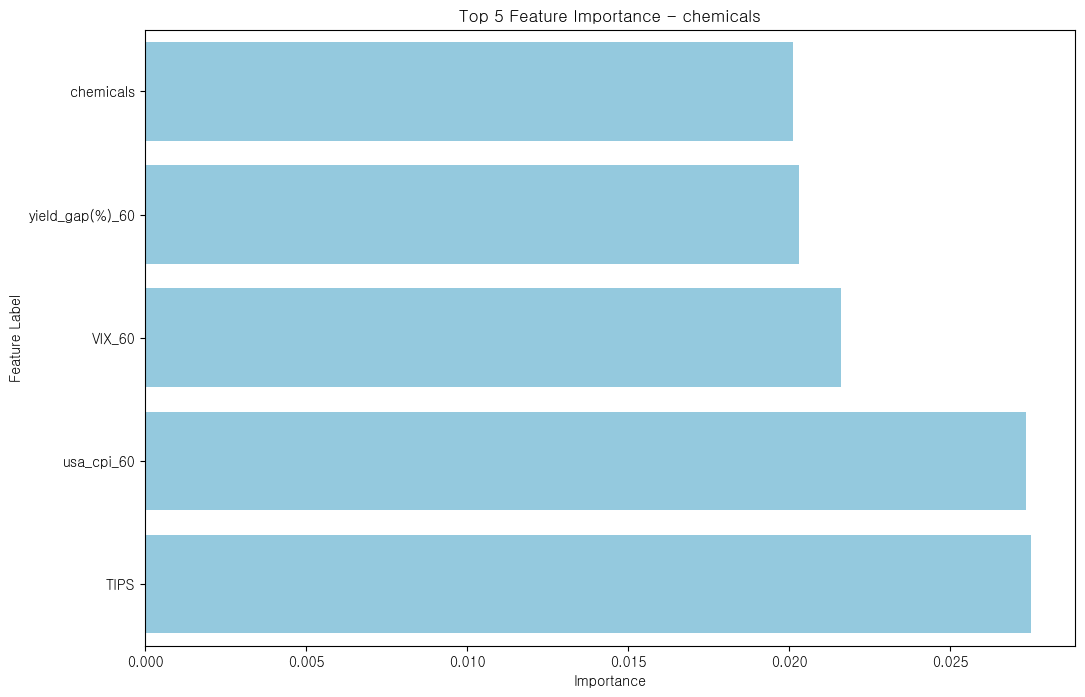

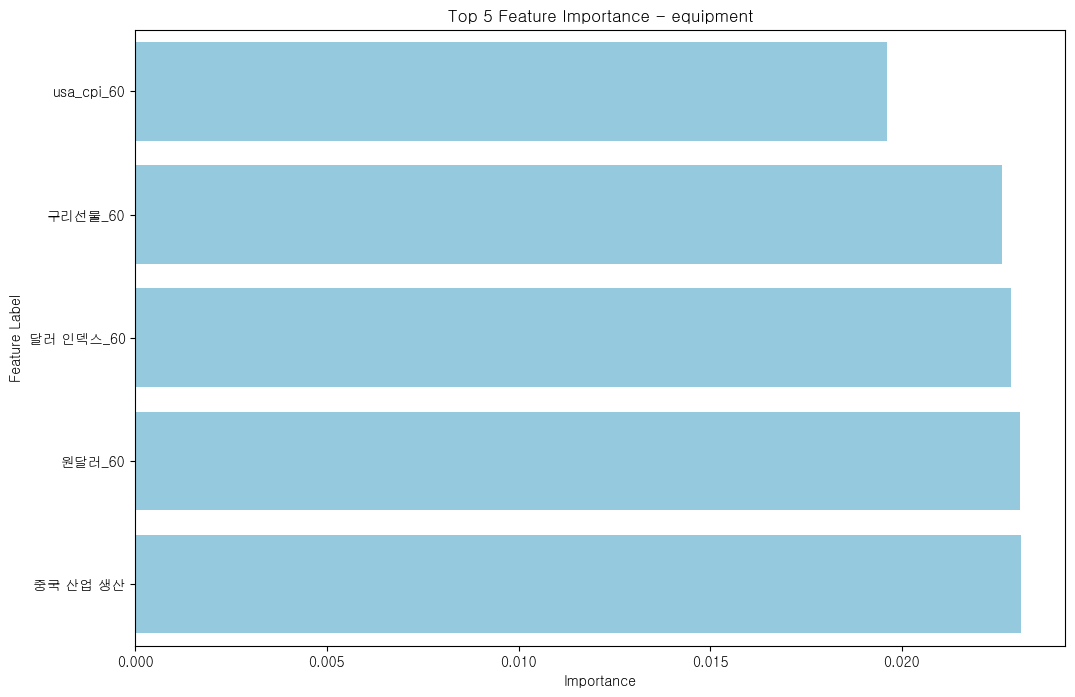

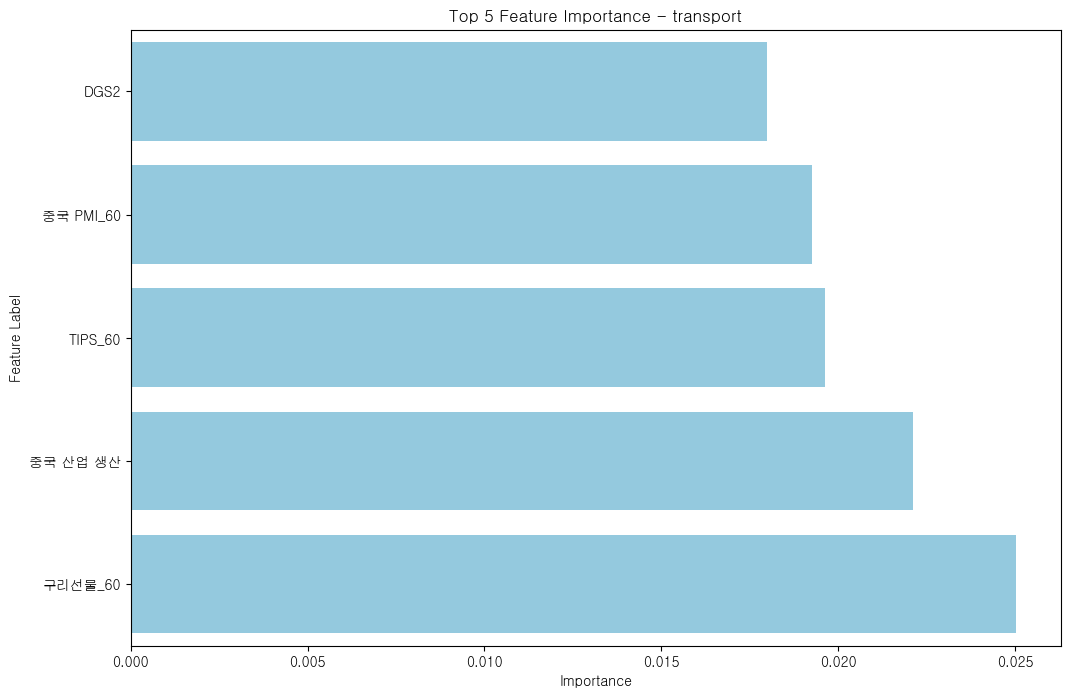

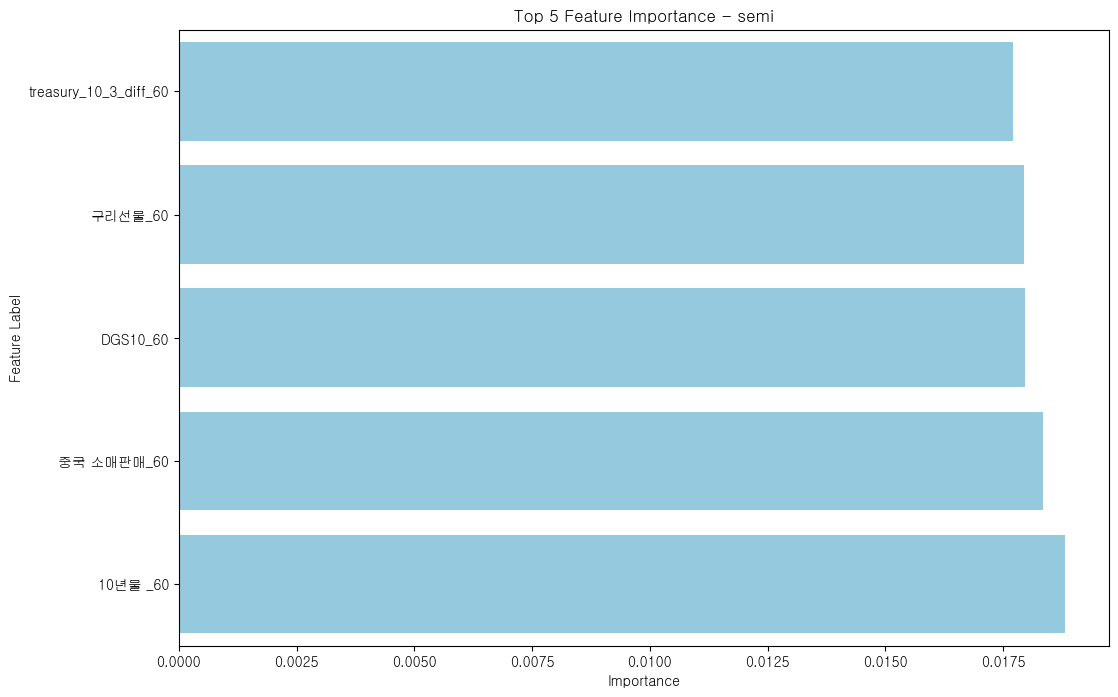

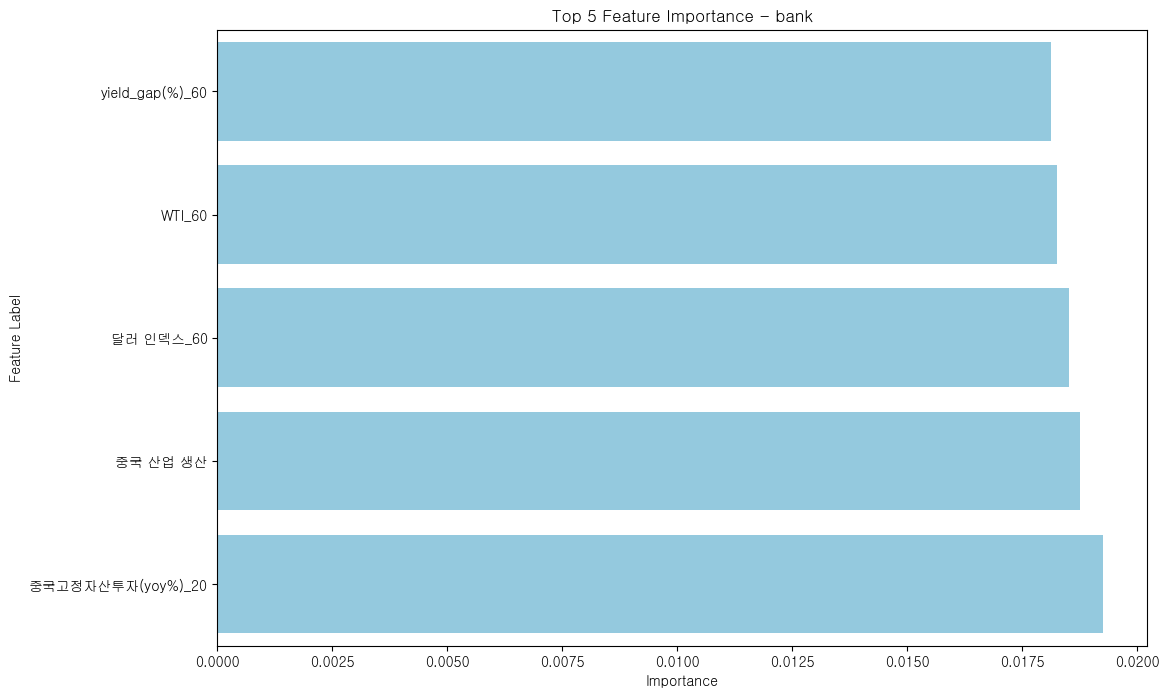

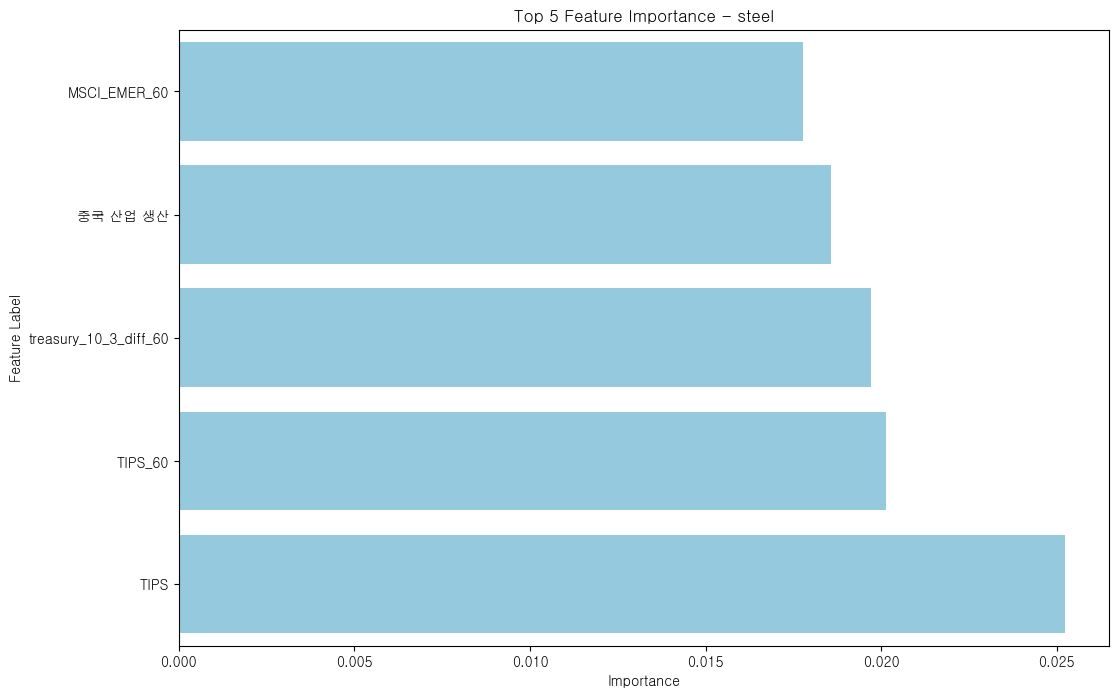

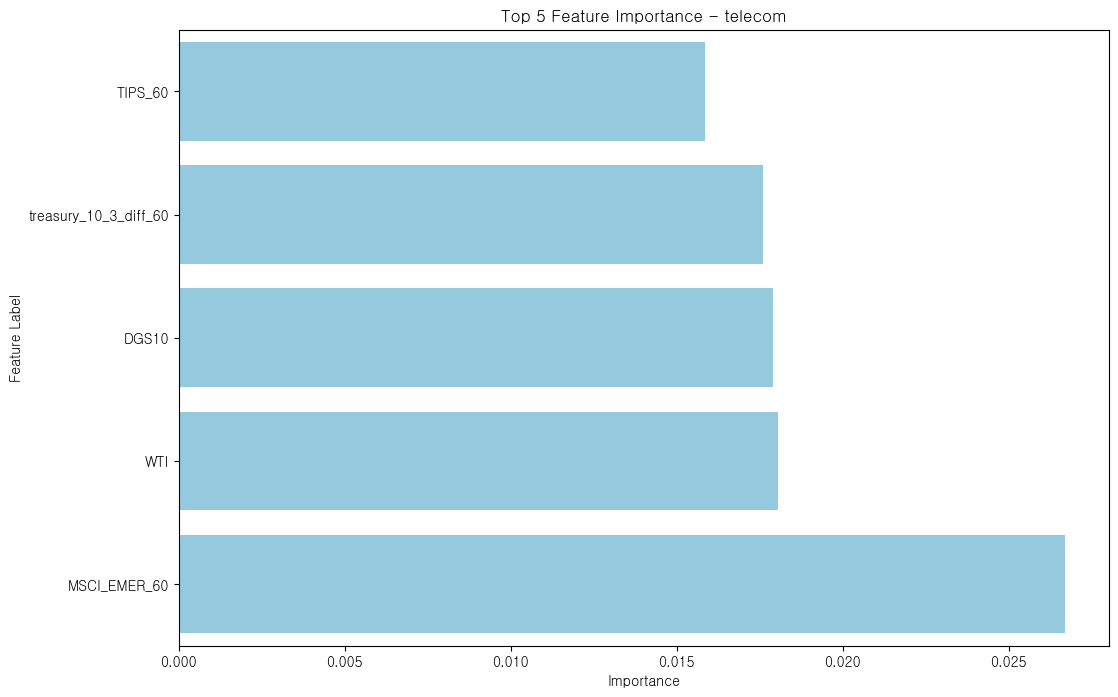

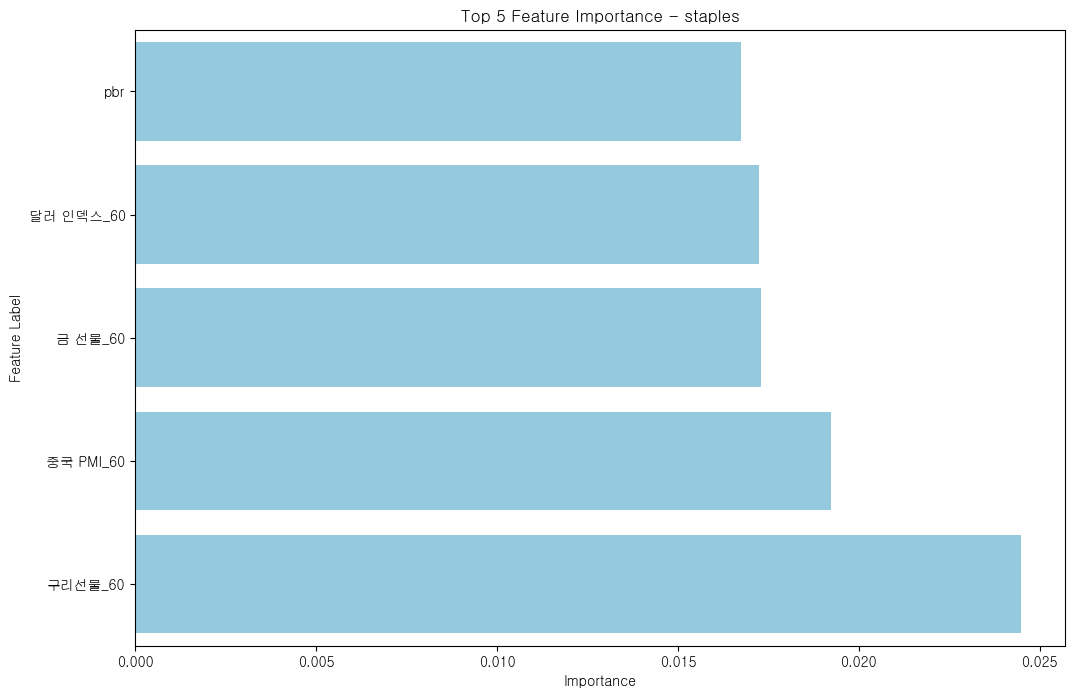

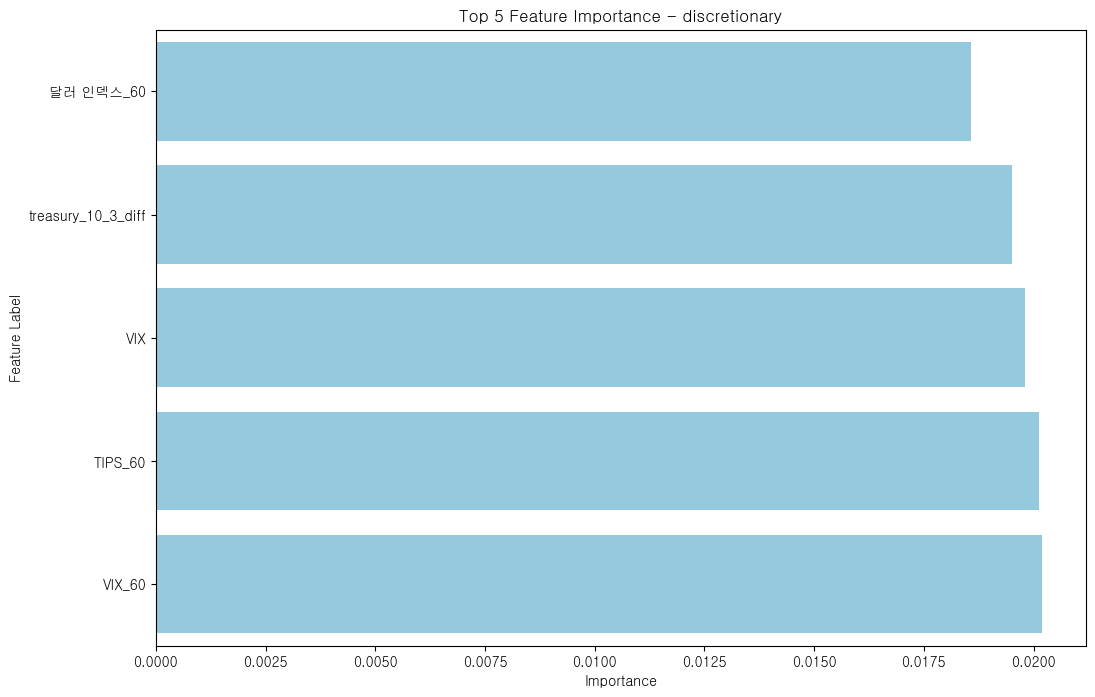

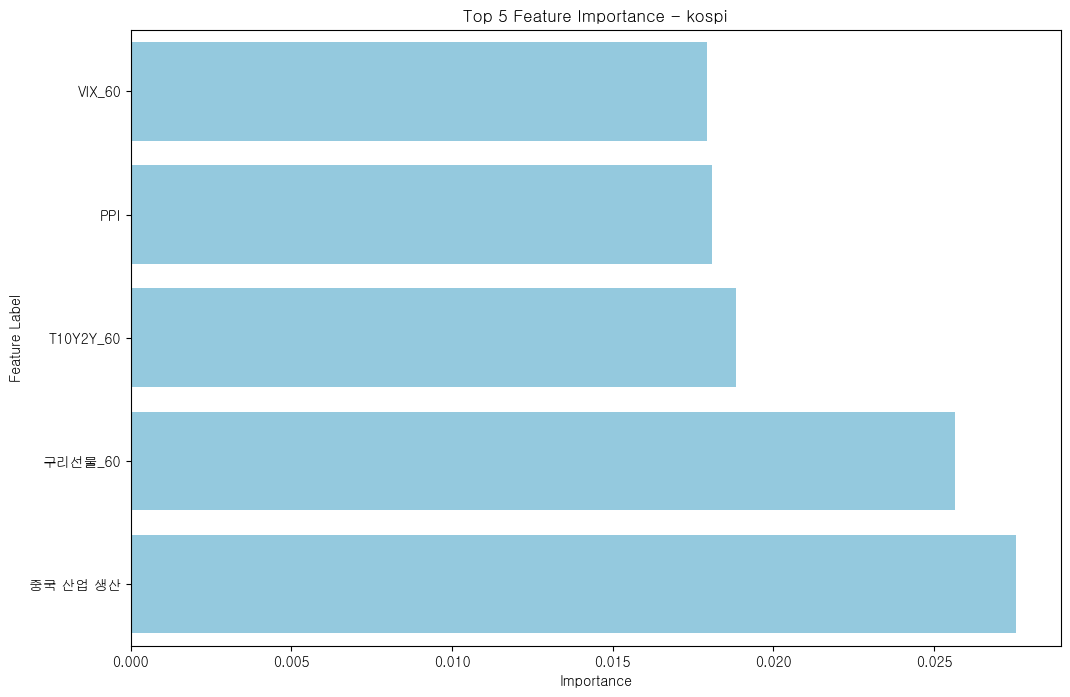

In [12]:
# 각 키워드별 상위 5개 특성의 인덱스와 중요도 출력
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']

    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]

    # RandomForestClassifier 초기화 및 학습
    rfc = RandomForestClassifier(n_estimators=best_estimator, 
                                 max_depth=best_depth, 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)
    rfc.fit(X_train, y_train)

    # Feature Importance 계산
    feats = {}
    for feature, importance in zip(range(X_train.shape[1]), rfc.feature_importances_):
        feats[feature] = importance

    # 중요도 순으로 정렬하여 상위 5개와 하위 5개 선택
    sorted_feats = sorted(feats.items(), key=lambda x: x[1], reverse=True)
    top_5_importances = sorted_feats[:5]
    bottom_5_importances = sorted_feats[-5:]
    # 결과 출력
    print(f"{keyword} 키워드의 상위 5개 특성:")
    for feature_index, importance in top_5_importances:
        feature_name = column_names_per_keyword[keyword][feature_index]  # 열 이름 가져오기
        print(f"Feature Name: {feature_name}, Importance: {importance:.4f}")
    print()
    print(f"{keyword} 키워드의 하위 5개 특성:")
    for feature_index, importance in bottom_5_importances:
        feature_name = column_names_per_keyword[keyword][feature_index]  # 열 이름 가져오기
        print(f"Feature Name: {feature_name}, Importance: {importance:.4f}")
    print()

### 이후 이것을 그래프로 변환해서 출력
### 생각보다 자동차지수와 중국 지표 금 구리 이런게 영향을 많이 미치는구마잉!
# 상위 5개 특성의 이름과 중요도 분리하여 그래프 출력
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']

    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]

    # RandomForestClassifier 초기화 및 학습
    rfc = RandomForestClassifier(n_estimators=best_estimator, 
                                 max_depth=best_depth, 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)
    rfc.fit(X_train, y_train)

    # Feature Importance 계산
    feats = {}
    for feature, importance in zip(range(X_train.shape[1]), rfc.feature_importances_):
        feats[feature] = importance

    # 중요도 순으로 정렬하여 상위 5개 선택
    sorted_feats = sorted(feats.items(), key=lambda x: x[1], reverse=True)
    top_5_importances = sorted_feats[:5]

    # 상위 5개 특성의 이름과 중요도 분리
    top_5_features = [column_names_per_keyword[keyword][feature_index] for feature_index, _ in top_5_importances]
    top_5_importance_values = [importance for _, importance in top_5_importances]

    # 그래프 출력
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_5_importance_values, y=top_5_features, color='skyblue')
    plt.title(f'Top 5 Feature Importance - {keyword}')
    plt.xlabel('Importance')
    plt.ylabel('Feature Label')
    plt.gca().invert_yaxis()  # y축 라벨 역순으로 표시
    plt.show()


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# 디렉토리가 없다면 생성
if not os.path.exists('plk_folder_05_new'):
    os.makedirs('plk_folder_05_new')

# 각 키워드별로 최종 모델 학습 및 모델 저장
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']

    # RandomForestClassifier 초기화
    rfc = RandomForestClassifier(n_estimators=best_estimators_per_keyword[keyword], 
                                 max_depth=best_depths_per_keyword[keyword], 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)

    # 최종 모델 학습
    rfc.fit(X_train, y_train)

    # 모델 저장
    filename = f"plk_folder_05_new/{keyword}_model.pkl"
    dump(rfc, filename)
    print(f"Model for {keyword} keyword saved as {filename}")

print("\n< AI model: save >")

# 모델 로드
loaded_models = {}

# 각 키워드별로 모델 로드
for keyword in keywords:
    filename = f"plk_folder_05_new/{keyword}_model.pkl"
    if os.path.exists(filename):
        loaded_models[keyword] = load(filename)
        print(f"Model for {keyword} keyword loaded from {filename}")
    else:
        print(f"Model file for {keyword} keyword does not exist: {filename}")

print("\n< AI model: load >")


Model for auto keyword saved as plk_folder_05_new/auto_model.pkl
Model for construct keyword saved as plk_folder_05_new/construct_model.pkl
Model for capital_market keyword saved as plk_folder_05_new/capital_market_model.pkl
Model for chemicals keyword saved as plk_folder_05_new/chemicals_model.pkl
Model for equipment keyword saved as plk_folder_05_new/equipment_model.pkl
Model for transport keyword saved as plk_folder_05_new/transport_model.pkl
Model for semi keyword saved as plk_folder_05_new/semi_model.pkl
Model for bank keyword saved as plk_folder_05_new/bank_model.pkl
Model for steel keyword saved as plk_folder_05_new/steel_model.pkl
Model for telecom keyword saved as plk_folder_05_new/telecom_model.pkl
Model for staples keyword saved as plk_folder_05_new/staples_model.pkl
Model for discretionary keyword saved as plk_folder_05_new/discretionary_model.pkl
Model for kospi keyword saved as plk_folder_05_new/kospi_model.pkl

< AI model: save >
Model for auto keyword loaded from plk_fo

auto
S_buy: 0.1429
buy: 0.4754
sell: 0.3817

construct
S_buy: 0.3150
buy: 0.4750
sell: 0.2100

capital_market
S_buy: 0.1533
buy: 0.3780
sell: 0.4687

chemicals
S_buy: 0.1587
buy: 0.4241
sell: 0.4173

equipment
S_buy: 0.4000
buy: 0.2500
sell: 0.3500

transport
S_buy: 0.4740
buy: 0.2116
sell: 0.3144

semi
S_buy: 0.1848
buy: 0.2525
sell: 0.5628

bank
S_buy: 0.4500
buy: 0.4510
sell: 0.0990

steel
S_buy: 0.2105
buy: 0.3684
sell: 0.4211

telecom
S_buy: 0.1429
buy: 0.7143
sell: 0.1429

staples
S_buy: 0.1115
buy: 0.3325
sell: 0.5560

discretionary
S_buy: 0.2500
buy: 0.3752
sell: 0.3748

kospi
S_buy: 0.2533
buy: 0.4146
sell: 0.3321

auto
0.1429   0.4754   0.3817   
construct
0.3150   0.4750   0.2100   
capital_market
0.1533   0.3780   0.4687   
chemicals
0.1587   0.4241   0.4173   
equipment
0.4000   0.2500   0.3500   
transport
0.4740   0.2116   0.3144   
semi
0.1848   0.2525   0.5628   
bank
0.4500   0.4510   0.0990   
steel
0.2105   0.3684   0.4211   
telecom
0.1429   0.7143   0.1429   
stap

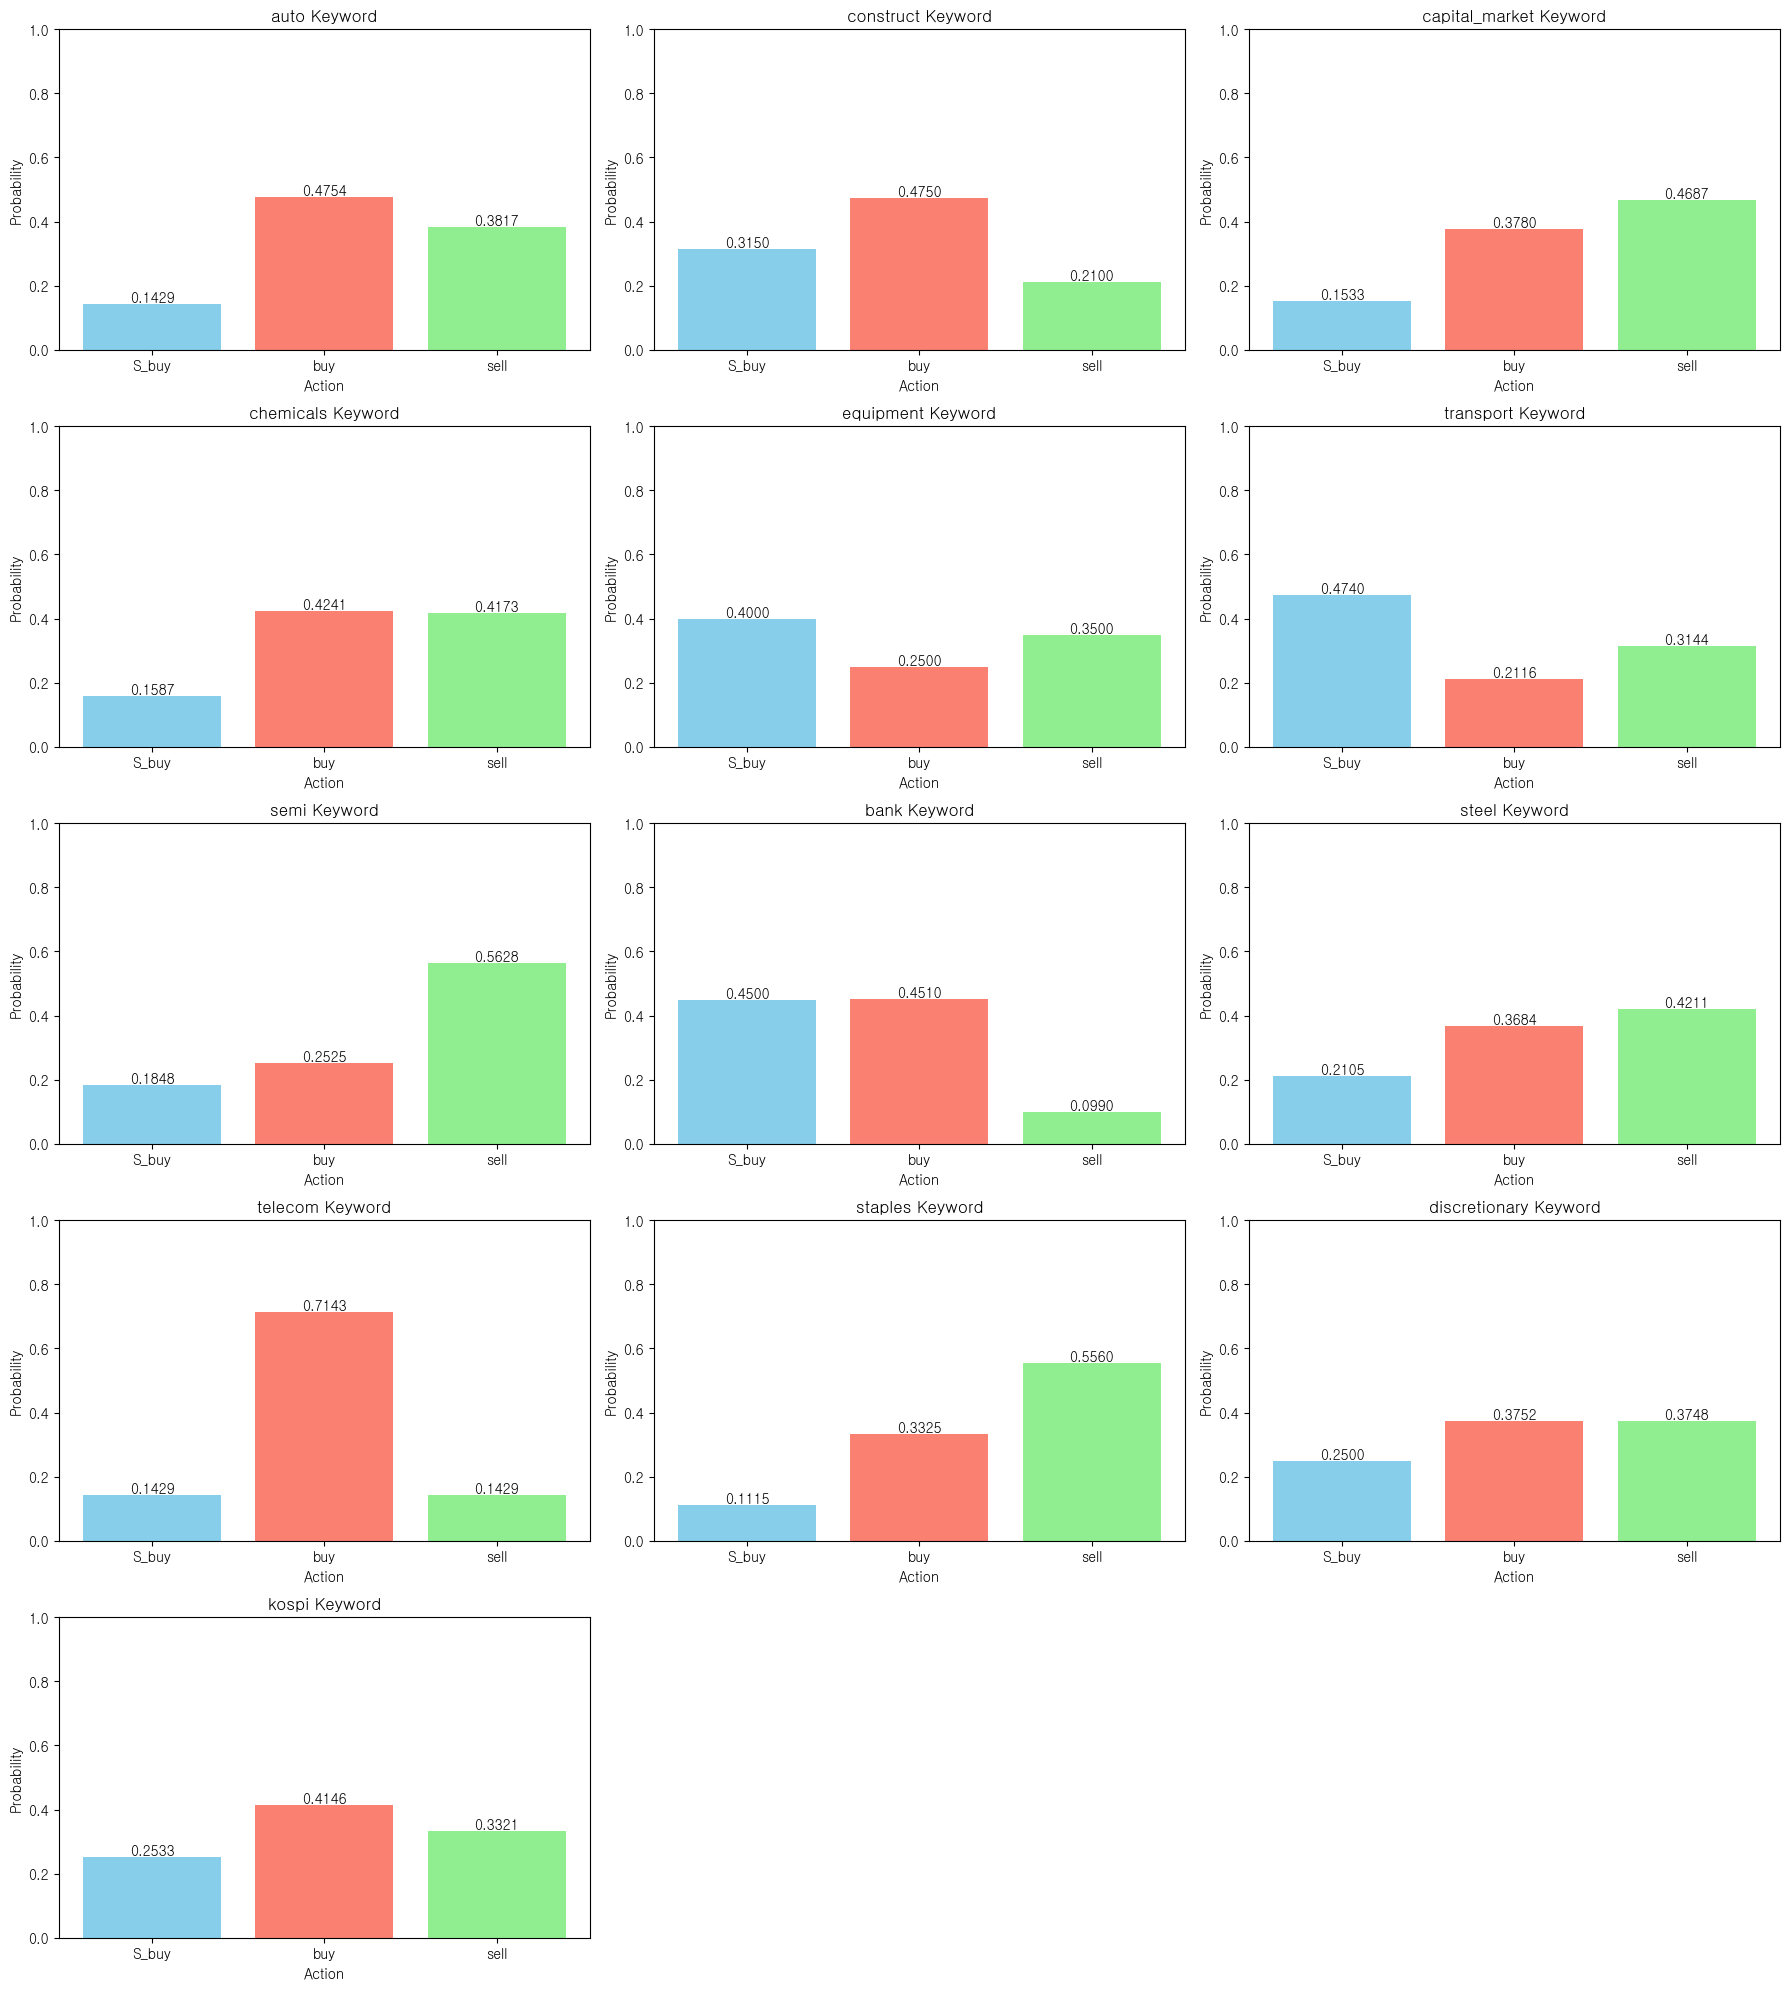

In [14]:
# 각 키워드별로 S_buy, buy, sell의 확률 예측
probabilities = {}
for keyword, model in loaded_models.items():
    # 마지막 행 데이터를 가져와서 예측에 사용
    X_test_last_row_keyword = last_rows[keyword].values.reshape(1, -1)
    # 첫 번째 열(해당 키워드)을 제외하고 예측에 사용
    X_test_last_row_keyword = X_test_last_row_keyword[:, 1:]
    # 각 클래스의 확률 예측
    prob_current = model.predict_proba(X_test_last_row_keyword)
    # 클래스 이름 가져오기
    y_names = model.classes_
    # 결과 저장
    probabilities[keyword] = {'S_buy': prob_current[0][0], 'buy': prob_current[0][1], 'sell': prob_current[0][2]}

# 출력
for keyword, probs in probabilities.items():
    print(keyword)
    for action, prob in probs.items():
        print(f'{action}: {prob:.4f}')
    print()

# 그래프로 출력
num_keywords = len(probabilities)
num_rows = (num_keywords + 2) // 3
num_cols = min(num_keywords, 3)
plt.figure(figsize=(6 * num_cols, 4 * num_rows))

for i, (keyword, probs) in enumerate(probabilities.items(), start=1):
    plt.subplot(num_rows, num_cols, i)
    plt.bar(probs.keys(), probs.values(), color=['skyblue', 'salmon', 'lightgreen'])
    plt.title(f'{keyword} Keyword')
    plt.xlabel('Action')
    plt.ylabel('Probability')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    print(f'{keyword}')
    for j, prob in enumerate(probs.values()):
        plt.text(j, prob, f'{prob:.4f}', ha='center', va='bottom')
        print(f'{prob:.4f}', end="   ")
    print()
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import pandas as pd
import os
from joblib import load

# 백테스트 데이터 로드
backtesting_path = 'backtesting_raw.xlsx'
backtesting_data = pd.read_excel(backtesting_path, sheet_name=None)

# 인덱스를 날짜 형식으로 변환 후 문자열로 변경
for keyword, df in backtesting_data.items():
    # 원본 인덱스 제거
    df.reset_index(drop=True, inplace=True)
    # 인덱스를 날짜 형식으로 변환
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    # 인덱스를 'date' 열로 설정
    df.set_index('date', inplace=True)
    print(f"{keyword} 키워드의 백테스트 데이터:")
    print(df.head())


auto 키워드의 백테스트 데이터:
              WTI  DGS2  DGS10  TIPS    VIX    PPI    per    pbr     원달러  \
date                                                                       
2010-05-03  86.19  1.00   3.72  1.32  20.19  173.9  15.23  15.23  1108.4   
2010-06-01  72.70  0.78   3.29  1.32  20.19  173.9  15.23  15.23  1108.4   
2010-07-01  72.95  0.63   2.96  1.21  28.53  176.1  15.45  15.45  1227.7   
2010-08-02  81.25  0.56   2.99  1.29  33.70  175.2  14.86  14.86  1153.8   
2010-09-01  73.97  0.50   2.86  1.04  21.74  174.8  14.96  14.96  1235.9   

                 원엔  ...   구리선물_60  중국고정자산투자(yoy%)_60  중국 PMI_60   금 선물_60  \
date                 ...                                                     
2010-05-03  1186.77  ...  0.002464          -0.003053  -0.000077  0.001188   
2010-06-01  1186.77  ...  0.002464          -0.003053  -0.000077  0.001188   
2010-07-01  1337.19  ...  0.002464          -0.003053  -0.000077  0.001188   
2010-08-02  1227.29  ...  0.002464          -0.003053  -0